In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import random
random.seed(10)
import pycountry
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import datetime as dt
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from keras import regularizers
from tensorflow.keras import metrics
import category_encoders as ce
from scipy import stats


## Load Data

In [2]:
dfolder = '../data/'

In [3]:
df_final = pd.read_csv(dfolder + 'preprocessed_df.csv')

In [4]:
df_final['deaths_all_pc']

0        6.492918
1        2.176669
2        0.000000
3        0.000000
4        0.000000
           ...   
79870    0.000000
79871    0.000000
79872    0.000000
79873    0.000000
79874    0.000000
Name: deaths_all_pc, Length: 79875, dtype: float64

## Preprocessing

In [5]:
df_final['country'] = df_final['Country Name']

In [6]:
df_final.country.nunique()

195

In [7]:
armedconfdf = df_final.drop(columns=['civilwar','Country Name', 'date'])

In [8]:
top_10_countries=pd.DataFrame(armedconfdf.groupby('country')['deaths_all_pc'].sum()).sort_values(by='deaths_all_pc',ascending=False).reset_index()
top_10_country_names=top_10_countries.country[:11]

In [9]:
df_final['armedconf'] = df_final['armedconf'].astype(int)
df_final['civilwar'] = df_final['civilwar'].astype(int)
df_final = df_final[df_final['year'] >= 2000]
df_final.drop(['MonthYear'], axis=1, inplace=True)


In [10]:
conf=df_final.copy()
conf['country']=list(conf.country)
conf=conf.set_index(['isocode','year','month'])
conf

,,,deaths,state_deaths,nonstate_deaths,onesided_deaths,civilian_deaths,month_year,Country Name,wb_pop,date,total_events,...,past6,past12,past60,past120,armedconf_since,num_regions,Adm1_Max,Adm1_Mean,Adm1_Median,country
isocode,year,month,,,,,,,,,,,,,,,,,,,,,
AFG,2000,1,54.0,54.0,0.0,0.0,26.0,2000-01-01,Afghanistan,19542982.0,2000-01-01,5224.0,...,16.706907,22.972855,180.652765,346.465884,0,32,629.252033,582.202685,578.869009,Afghanistan
AGO,2000,1,36.0,0.0,0.0,36.0,36.0,2000-01-01,Angola,16394062.0,2000-01-01,5420.0,...,5.984914,17.017786,27.334553,185.535914,0,20,189.309091,126.144306,129.261468,Angola
ALB,2000,1,0.0,0.0,0.0,0.0,0.0,2000-01-01,Albania,3089027.0,2000-01-01,5430.0,...,0.000000,0.193002,0.193002,0.193002,9,14,0.060606,0.039237,0.036156,Albania
ARE,2000,1,0.0,0.0,0.0,0.0,0.0,2000-01-01,United Arab Emirates,3275333.0,2000-01-01,978.0,...,0.000000,0.000000,0.000000,0.000000,133,8,0.012346,0.007773,0.007618,United Arab Emirates
ARG,2000,1,0.0,0.0,0.0,0.0,0.0,2000-01-01,Argentina,37070774.0,2000-01-01,2454.0,...,0.000000,0.000000,0.000000,0.249357,66,19,1.535714,0.295357,0.125364,Argentina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XKX,2023,5,0.0,0.0,0.0,0.0,0.0,2023-05-01,Kosovo,1786038.0,2023-05-01,650.0,...,0.000000,0.000000,0.000000,0.000000,412,10,0.000000,0.000000,0.000000,Kosovo
YEM,2023,5,0.0,0.0,0.0,0.0,0.0,2023-05-01,"Yemen, Rep.",32981641.0,2023-05-01,3358.0,...,0.927789,2.416496,101.723726,162.727194,2,20,200.276596,121.436293,118.934417,"Yemen, Rep."
ZAF,2023,5,0.0,0.0,0.0,0.0,0.0,2023-05-01,South Africa,59392255.0,2023-05-01,43244.0,...,0.000000,0.010102,0.102890,0.108207,22,11,14.751497,12.100576,13.784257,South Africa


### Train Test Split

In [11]:
def train_test_split_year(data, year):
    x_train = data[data.index.get_level_values('year') < year].drop(columns=['deaths_all_pc'])
    y_train = data[data.index.get_level_values('year') < year]['deaths_all_pc']
    x_test = data[data.index.get_level_values('year') >= year].drop(columns=['deaths_all_pc'])
    y_test = data[data.index.get_level_values('year') >= year]['deaths_all_pc']
    return x_train, x_test, y_train, y_test


In [12]:
country=list(set(conf.country))
# loop each country and collect train and test data 
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
for i in range(0,len(country)):
    data=conf[conf['country']==country[i]]
    x_train, x_test,y_train,y_test=train_test_split_year(data, 2018)
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

In [13]:
# concat each train data from each country 
X_train=pd.concat(X_train)
Y_train=pd.DataFrame(pd.concat(Y_train))
# concat each test data from each country 
X_test=pd.concat(X_test)
Y_test=pd.DataFrame(pd.concat(Y_test))


In [14]:
train = pd.concat([X_train, Y_train], axis=1)
test = pd.concat([X_test, Y_test], axis=1)

In [15]:

train.to_csv('test.csv')

## Normalizing

Here i'm taking the top 10 countries for model interpretability later.

X Scaling

In [16]:
# # indices
train_index = train.index
test_index = test.index
train_country = train['country']
test_country = test['country']

# normalize data 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train= scaler.fit_transform(train.drop(columns=['Country Name', 'month_year', 'date', 'country']))
scaled_test= scaler.transform(test.drop(columns=['Country Name', 'month_year', 'date', 'country']))

# convert back to DataFrame and add columns and index back
scaled_train=pd.DataFrame(data=scaled_train,columns=train.drop(columns=['Country Name', 'month_year', 'date', 'country']).columns, index=train_index)
scaled_test=pd.DataFrame(data=scaled_test,columns=test.drop(columns=['Country Name', 'month_year', 'date', 'country']).columns, index=test_index)

Y Scaling

In [17]:
scaled_train['country'] = train_country
scaled_test['country'] = test_country

y_train_2D = Y_train.values.reshape(-1, 1)
y_test_2D = Y_test.values.reshape(-1, 1)

Y_train = np.log1p(y_train_2D)
Y_test = np.log1p(y_test_2D)

# append the scaled y to the scaled X
scaled_train['deaths_all_pc'] = Y_train 
scaled_test['deaths_all_pc'] = Y_test

In [18]:
scaled_train.country.nunique()

195

In [19]:
scaled_test.country.nunique()
test_data_copy = scaled_test.copy()

## Model

In [20]:
def series_to_supervised(data, target_column_index, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        target_column_index: The index of the target column in data
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t)
    for i in range(n_in, -1, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t+1)
    cols.append(df[df.columns[target_column_index]].shift(-n_out))
    names += ['var%d(t+%d)' % (target_column_index+1, n_out)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# create the reshape function
def reshape_data(train,test):
    """
    Reshape 'train' and 'test' dataframes into a format suitable for supervised learning,
    splitting them into input features (X) and target labels (y), and reshaping input 
    features into a 3D format required by LSTM models in Keras.

    Arguments:
        train: Training dataframe, with the last column being the target column.
        test: Test dataframe, with the last column being the target column.

    Returns:
        x_train: Input features for training data, reshaped into 3D format.
        x_test: Input features for test data, reshaped into 3D format.
        y_train: Target labels for training data.
        y_test: Target labels for test data.
        reframed_train: Training data transformed into a supervised learning format.
    """
    
    target_column_index_train = train.shape[1] - 1
    target_column_index_test = test.shape[1] - 1
    #Frame as supervised learning and drop all time t columns except PM2.5
    reframed_train = series_to_supervised(train, target_column_index_train, 1, 1)
    reframed_test = series_to_supervised(test, target_column_index_test, 1, 1)
    reframed_train
    # split into train and test sets
    train= reframed_train.values
    test=reframed_test.values
    # split into input and outputs
    ''
    train_X, y_train = train[:, :-1], train[:, -1]
    test_X, y_test = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train,x_test,y_train, y_test, reframed_train

In [21]:
# Create a new dataframe for train data
train_data = pd.DataFrame()

# Add all X_train columns
for col in scaled_train.columns:
    if col != 'country':
        train_data[col] = scaled_train[col]

# Create target encoder
encoder = ce.TargetEncoder(smoothing=2.0)

# Fit and transform 'country' on training data
train_data['country'] = encoder.fit_transform(scaled_train['country'], Y_train)

# Create a new dataframe for test data
test_data = pd.DataFrame()

# Add all X_test columns
for col in scaled_test.columns:
    if col != 'country':
        test_data[col] = scaled_test[col]

# Transform 'country' on testing data
test_data['country'] = encoder.transform(scaled_test['country'])

train_data['deaths_all_pc'] = Y_train
test_data['deaths_all_pc'] = Y_test
train_data['deaths_all_pc'] = train_data.pop('deaths_all_pc')
test_data['deaths_all_pc'] = test_data.pop('deaths_all_pc')

/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_66802/2701022734.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data[col] = scaled_train[col]
/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_66802/2701022734.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data[col] = scaled_train[col]
/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_66802/2701022734.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

In [22]:
test_data.country.nunique()

98

In [23]:
train_data.country.nunique()

98

In [24]:
train_data

deaths  state_deaths  nonstate_deaths  onesided_deaths  \
isocode year month                                                             
CHN     2000 1      0.000000      0.000000              0.0         0.000000   
             2      0.000000      0.000000              0.0         0.000000   
             3      0.000000      0.000000              0.0         0.000000   
             4      0.000000      0.000000              0.0         0.000000   
             5      0.000000      0.000000              0.0         0.000000   
...                      ...           ...              ...              ...   
BDI     2017 8      0.000847      0.000457              0.0         0.001026   
             9      0.000988      0.000000              0.0         0.002394   
             10     0.000141      0.000000              0.0         0.000342   
             11     0.000141      0.000000              0.0         0.000342   
             12     0.000564      0.000305              0.0         0.000684   

                    civilian_deaths    wb_pop  total_events  total_events_gov  \
isocode year month                                                              
CHN     2000 1             0.000000  0.904332      0.006915          0.009607   
             2             0.000000  0.904332      0.004553          0.005958   
             3             0.000000  0.904332      0.006518          0.009315   
             4             0.000000  0.904332      0.006019          0.008039   
             5             0.000000  0.904332      0.005276          0.006824   
...                             ...       ...           ...               ...   
BDI     2017 8             0.000715  0.007970      0.000929          0.000944   
             9             0.001667  0.007970      0.001585          0.001541   
             10            0.000238  0.007970      0.000882          0.000913   
             11            0.000238  0.007970      0.001129          0.001340   
             12            0.000476  0.007970      0.000634          0.000595   

                    total_events_opp  share_events_count_events_1  ...  \
isocode year month                                                 ...   
CHN     2000 1              0.008073                     0.121763  ...   
             2              0.004231                     0.125350  ...   
             3              0.004533                     0.118594  ...   
             4              0.007814                     0.116728  ...   
             5              0.005741                     0.123478  ...   
...                              ...                          ...  ...   
BDI     2017 8              0.002374                     0.091463  ...   
             9              0.004101                     0.123659  ...   
             10             0.002115                     0.119914  ...   
             11             0.001511                     0.115481  ...   
             12             0.001856                     0.118480  ...   

                      past12        past60       past120  armedconf_since  \
isocode year month                                                          
CHN     2000 1      0.000000  2.629043e-07  2.767475e-07         0.364943   
             2      0.000000  2.629043e-07  2.767475e-07         0.367816   
             3      0.000000  2.629043e-07  2.767475e-07         0.370690   
             4      0.000000  2.629043e-07  2.767475e-07         0.373563   
             5      0.000000  2.629043e-07  3.976403e-08         0.376437   
...                      ...           ...           ...              ...   
BDI     2017 8      0.000835  3.425130e-03  9.285505e-04         0.000000   
             9      0.000845  3.475861e-03  9.346844e-04         0.000000   
             10     0.000732  3.483108e-03  8.757525e-04         0.002874   
             11     0.000631  3.416073e-03  8.383691e-04         0.005747   
             12     0.000605  3.445062e-

In [25]:
x_train,x_test,y_train,y_test,example =reshape_data(train_data,test_data)

In [26]:
example

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  \
isocode year month                                                          
CHN     2000 2       0.000000   0.000000        0.0   0.000000   0.000000   
             3       0.000000   0.000000        0.0   0.000000   0.000000   
             4       0.000000   0.000000        0.0   0.000000   0.000000   
             5       0.000000   0.000000        0.0   0.000000   0.000000   
             6       0.000000   0.000000        0.0   0.000000   0.000000   
...                       ...        ...        ...        ...        ...   
BDI     2017 7       0.000141   0.000000        0.0   0.000342   0.000238   
             8       0.000282   0.000000        0.0   0.000684   0.000476   
             9       0.000847   0.000457        0.0   0.001026   0.000715   
             10      0.000988   0.000000        0.0   0.002394   0.001667   
             11      0.000141   0.000000        0.0   0.000342   0.000238   

                    var6(t-1)  var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  \
isocode year month                                                           
CHN     2000 2       0.904332   0.006915   0.009607   0.008073    0.121763   
             3       0.904332   0.004553   0.005958   0.004231    0.125350   
             4       0.904332   0.006518   0.009315   0.004533    0.118594   
             5       0.904332   0.006019   0.008039   0.007814    0.116728   
             6       0.904332   0.005276   0.006824   0.005741    0.123478   
...                       ...        ...        ...        ...         ...   
BDI     2017 7       0.007970   0.000812   0.000917   0.002374    0.144270   
             8       0.007970   0.001244   0.001813   0.004101    0.131359   
             9       0.007970   0.000929   0.000944   0.002374    0.091463   
             10      0.007970   0.001585   0.001541   0.004101    0.123659   
             11      0.007970   0.000882   0.000913   0.002115    0.119914   

                    ...    var96(t-0)    var97(t-0)  var98(t-0)  var99(t-0)  \
isocode year month  ...                                                       
CHN     2000 2      ...  2.629043e-07  2.767475e-07    0.367816    0.137339   
             3      ...  2.629043e-07  2.767475e-07    0.370690    0.137339   
             4      ...  2.629043e-07  2.767475e-07    0.373563    0.133047   
             5      ...  2.629043e-07  3.976403e-08    0.376437    0.137339   
             6      ...  2.629043e-07  3.976403e-08    0.379310    0.137339   
...                 ...           ...           ...         ...         ...   
BDI     2017 7      ...  3.381646e-03  9.219736e-04    0.005747    0.064378   
             8      ...  3.425130e-03  9.285505e-04    0.000000    0.060086   
             9      ...  3.475861e-03  9.346844e-04    0.000000    0.077253   
             10     ...  3.483108e-03  8.757525e-04    0.002874    0.068670   
             11     ...  3.416073e-03  8.383691e-04    0.005747    0.064378   

                    var100(t-0)  var101(t-0)  var102(t-0)  var103(t-0)  \
isocode year month                                                       
CHN     2000 2         0.004579     0.004085     0.004985     0.000103   
             3         0.004668     0.004218     0.005013     0.000103   
             4         0.004668     0.003803     0.004959     0.000103   
             5         0.004668     0.003990     0.004985     0.000103   
             6         0.004579     0.004002     0.004994     0.000103   
...                         ...          ...          ...          ...   
BDI     2017 7         0.051231     0.041468     0.042349     0.300319   
             8         0.035891     0.039186     0.041076     0.300319   
             9         0.051231     0.039696     0.039452     0.300319   
             10        0.035248     0.038112     0.038755     0.300319   
             11        0.033489     0.034885     0.035485     0.300319   

            

In [28]:
model = Sequential()
model.add(LSTM(60, input_shape=(x_train.shape[1], x_train.shape[2]), kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))
model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001))

early_stop = EarlyStopping(monitor='loss', patience=3)

history = model.fit(x_train, y_train, epochs=30, batch_size=50, verbose=1, shuffle=False, callbacks=[early_stop])


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-06-29 22:26:06.838566: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-29 22:26:06.838758: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/30


2023-06-29 22:26:07.104102: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-29 22:26:07.567929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 22:26:07.738568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/842 [..............................] - ETA: 14:09 - loss: 2.2137

2023-06-29 22:26:07.939021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


842/842 [==============================] - 8s 9ms/step - loss: 0.9121
Epoch 2/30
842/842 [==============================] - 7s 9ms/step - loss: 0.1075
Epoch 3/30
842/842 [==============================] - 7s 9ms/step - loss: 0.0396
Epoch 4/30
842/842 [==============================] - 7s 9ms/step - loss: 0.0325
Epoch 5/30
842/842 [==============================] - 7s 9ms/step - loss: 0.0294
Epoch 6/30
842/842 [==============================] - 7s 9ms/step - loss: 0.0275
Epoch 7/30
842/842 [==============================] - 8s 9ms/step - loss: 0.0261
Epoch 8/30
842/842 [==============================] - 7s 9ms/step - loss: 0.0251
Epoch 9/30
842/842 [==============================] - 7s 9ms/step - loss: 0.0242
Epoch 10/30
842/842 [==============================] - 7s 9ms/step - loss: 0.0235
Epoch 11/30
842/842 [==============================] - 7s 9ms/step - loss: 0.0230
Epoch 12/30
842/842 [==============================] - 7s 9ms/step - loss: 0.0225
Epoch 13/30
842/842 [===============

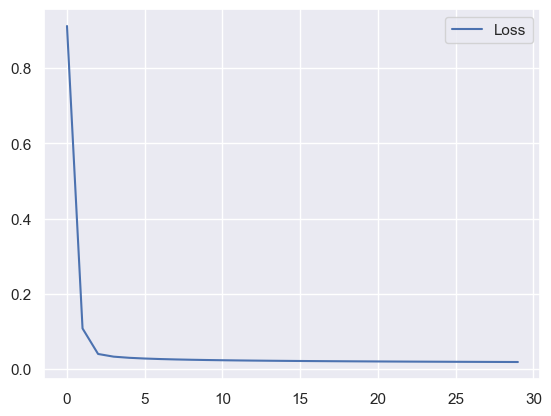

In [29]:
# plot history
plt.plot(history.history['loss'], label='Loss')
plt.legend()
plt.show()

In [30]:
y_pred = model.predict(x_test)

  1/397 [..............................] - ETA: 2:15

2023-06-29 22:30:04.051871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-29 22:30:04.142560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


397/397 [==============================] - 2s 3ms/step


reverting log for interpretability

In [31]:
y_pred = np.expm1(y_pred)
y_test= np.expm1(Y_test)

In [32]:
y_pred.shape,y_test.shape


((12673, 1), (12675, 1))

In [33]:
#  y_test prediction has one month lag so we need re-match the date 
len([i[0] for i in y_pred][:]),len(y_test[:-2])  


(12673, 12673)

In [34]:
len(y_test)

12675

In [35]:
len(y_pred)

12673

## Interpretation

In [36]:
y_hat_aligned = np.array([i[0] for i in y_pred][0:]) # discarding the first two elements
y_test_aligned = y_test[:-2]  # discarding the last two elements

print(len(y_hat_aligned), len(y_test_aligned))  # check if lengths are now the same

pa = pd.DataFrame()
pa['Month'] = X_test.reset_index().month.iloc[0:-2]  # also adjusted here
pa['Year'] = X_test.reset_index().year.iloc[0:-2]  # and here
pa['Prediction'] = y_hat_aligned
pa['Actual Values'] = y_test_aligned
pa.head()


12673 12673


,Month,Year,Prediction,Actual Values
0,1,2018,0.0,0.0
1,2,2018,0.0,0.0
2,3,2018,0.0,0.0
3,4,2018,0.0,0.0
4,5,2018,0.0,0.0


In [37]:
pa['Actual Values'].sum()

1285.350545723436

In [38]:
print(y_test_aligned.shape)
print(y_hat_aligned.shape)


(12673, 1)
(12673,)


RMSE:  0.6371996407614714


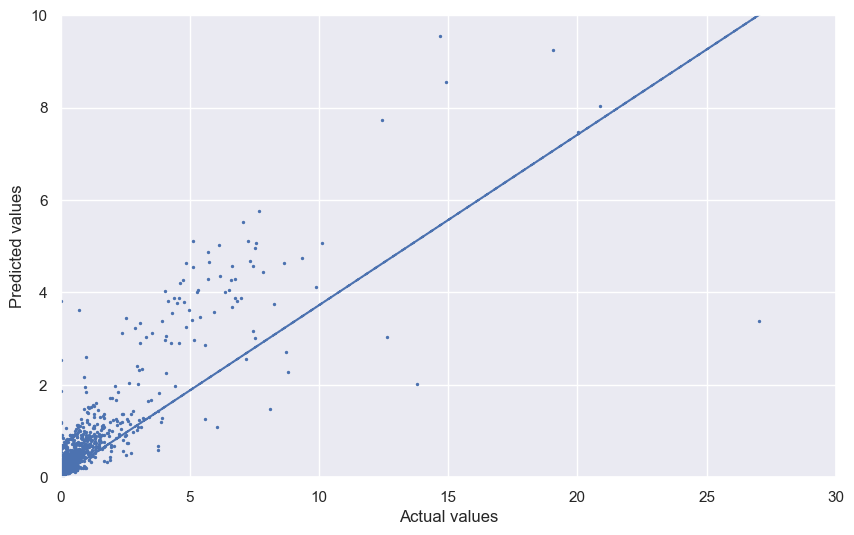

In [39]:
# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test_aligned, y_hat_aligned))
print('RMSE: ', rmse)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_aligned, y_hat_aligned, s=2)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

# Set the limits of the x and y axes
# NOTE: Replace 'xmin', 'xmax', 'ymin', and 'ymax' with the appropriate values.
plt.xlim(0, 30)
plt.ylim(0, 10)

# Fit a line to the predictions
z = np.polyfit(y_test_aligned.flatten(), y_hat_aligned, 1)
p = np.poly1d(z)
plt.plot(y_test_aligned, p(y_test_aligned), "b--")


Metrics

In [40]:

mse = mean_squared_error(y_test_aligned, y_hat_aligned)
print('Mean Squared Error: ', mse)
rmse = np.sqrt(mse)
print('Root Mean Squared Error: ', rmse)
mae = mean_absolute_error(y_test_aligned, y_hat_aligned)
print('Mean Absolute Error: ', mae)
r2 = r2_score(y_test_aligned, y_hat_aligned)
print('R-squared score: ', r2)


Mean Squared Error:  0.40602338218654815
Root Mean Squared Error:  0.6371996407614714
Mean Absolute Error:  0.05369520971393978
R-squared score:  0.5348481046653799


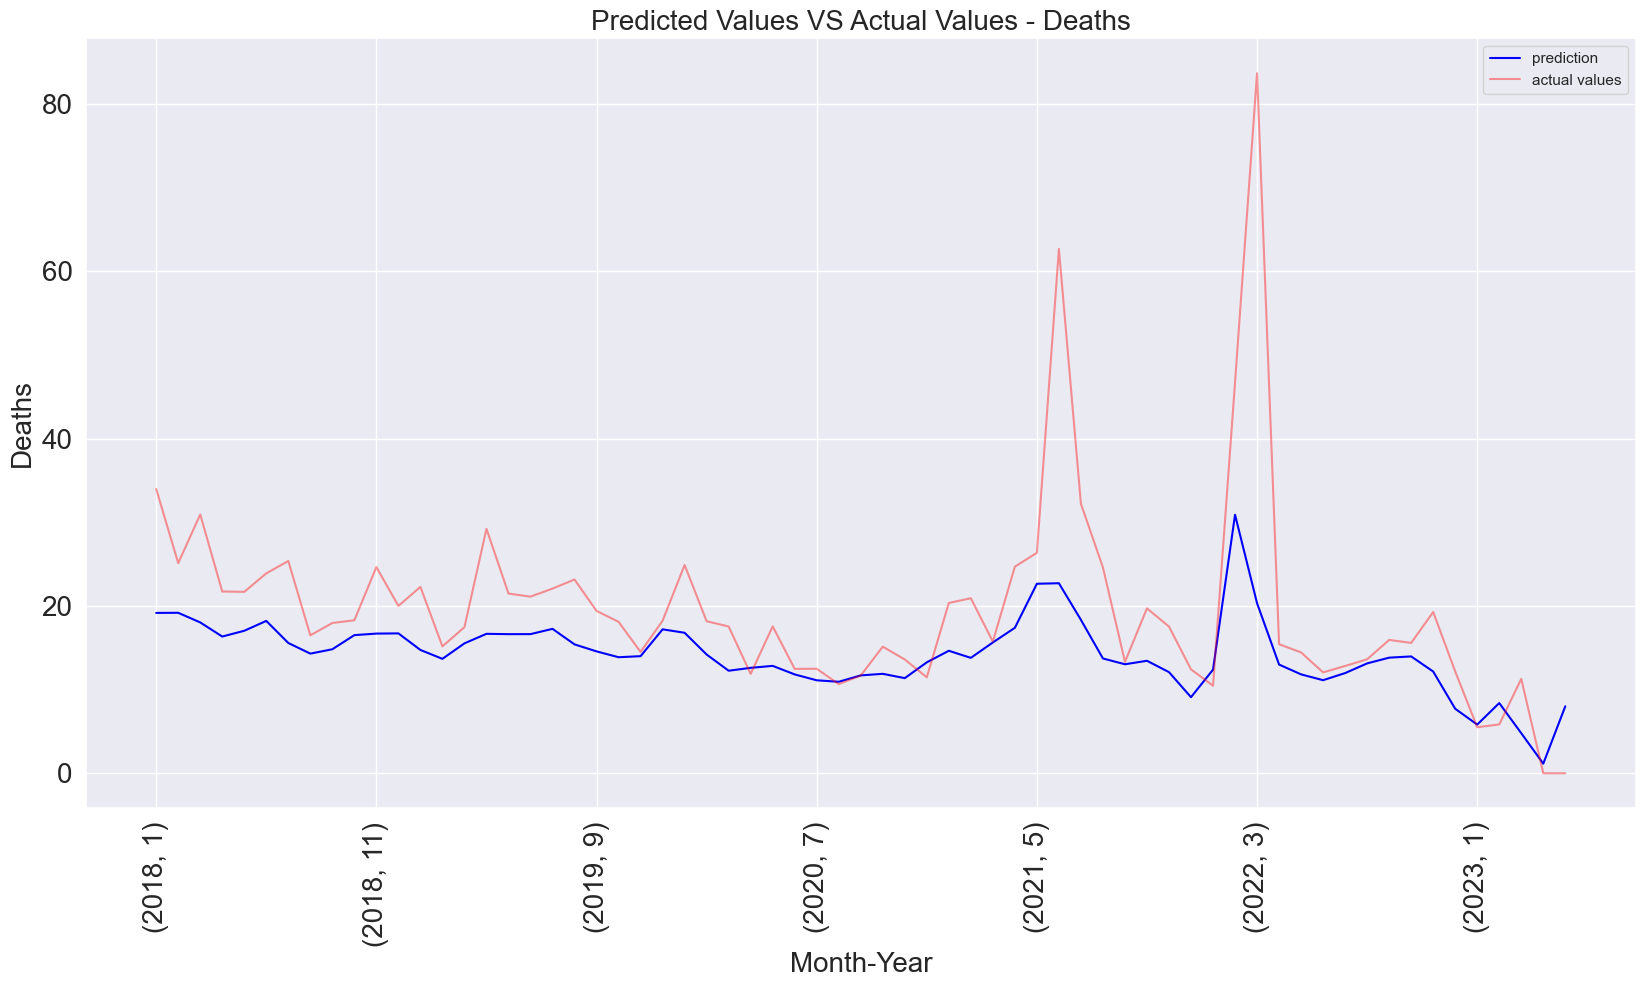

In [41]:
plt.figure(figsize=(20,10))
pa.groupby(['Year', 'Month'])['Prediction'].sum().plot(kind='line', label='prediction', color='blue', alpha=1)
pa.groupby(['Year', 'Month'])['Actual Values'].sum().plot(kind='line', label='actual values', color='red', alpha=0.4)
plt.xticks(rotation=90, size=20)
plt.yticks(size=20)

plt.ylabel('Deaths', fontsize=20)
plt.xlabel('Month-Year', fontsize=20)
plt.title('Predicted Values VS Actual Values - Deaths', fontsize=20)
plt.legend()


In [42]:
def reshape_test_data(test):
    target_column_index = test.shape[1] - 1
    # Frame as supervised learning and drop all time t columns except PM2.5
    reframed_test = series_to_supervised(test, target_column_index, 1, 1)
    # split into input and outputs
    test_values = reframed_test.values
    test_X, y_test = test_values[:, :-1], test_values[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_test, y_test

In [43]:
test_data_copy['deaths_all_pc']= test_data_copy.pop('deaths_all_pc')

Let's predict using the same model but now for a subset of countries. 

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 26ms/step
Length of y_pred: 63
Length of test_labels: 63
Number of NaN values in y_pred: 0
Number of NaN values in test_labels: 0
Rwanda - Mean Absolute Error: 0.08529342260024929, Mean Squared Error: 0.007586499219540517


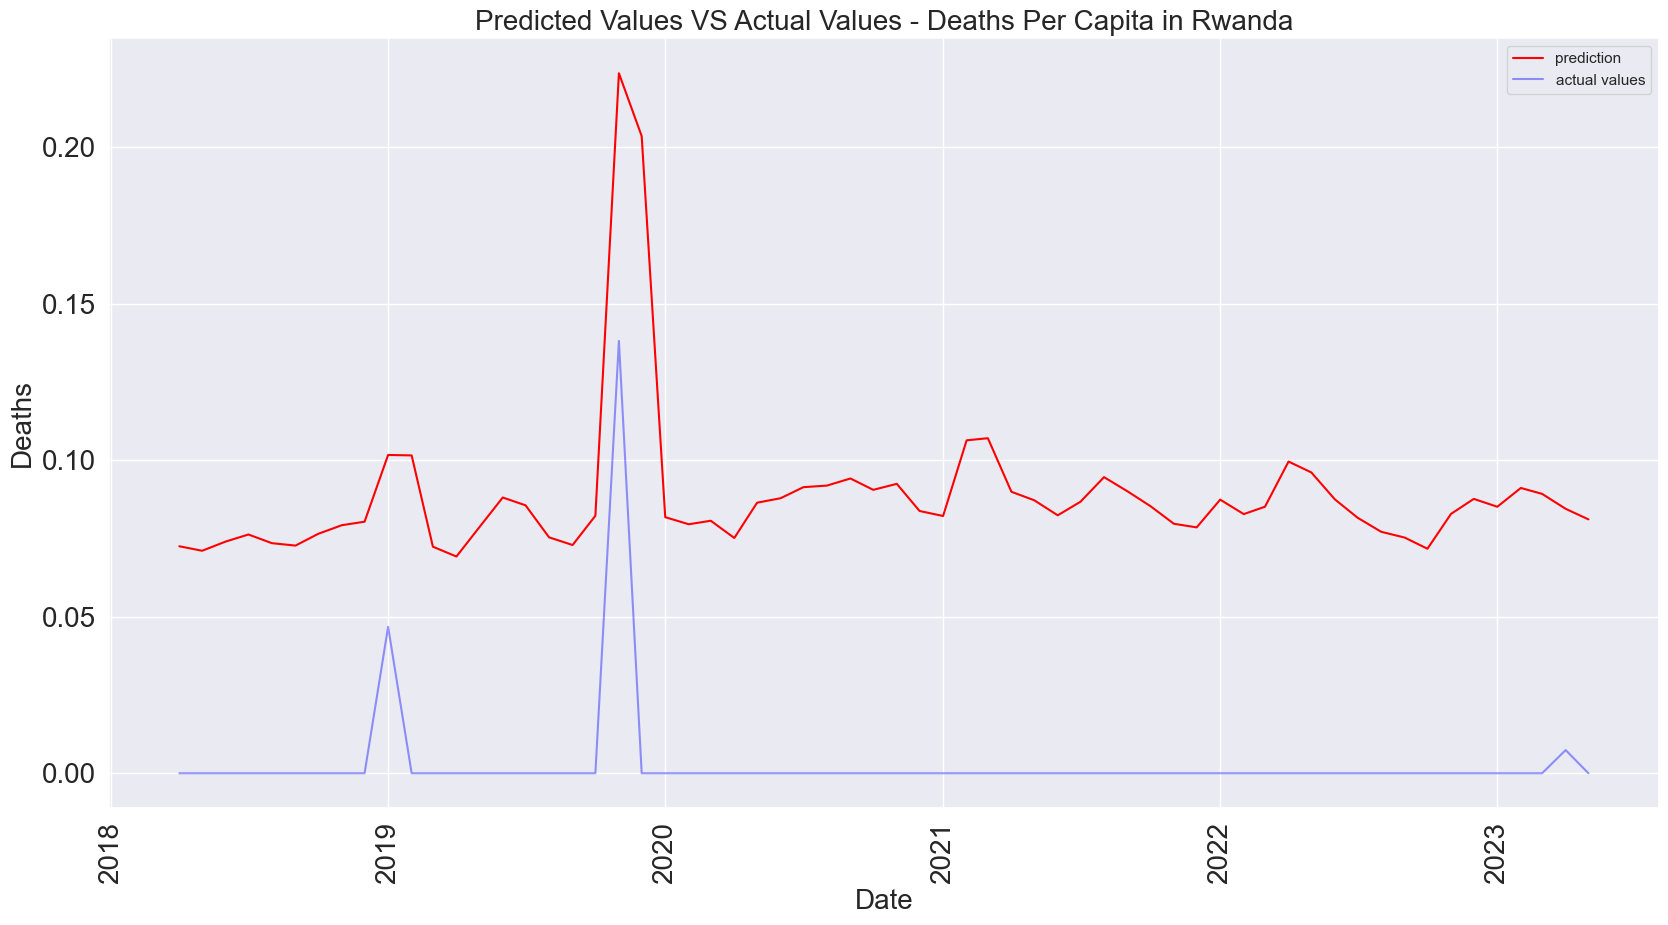

2/2 [==============================] - 0s 5ms/step
Length of y_pred: 63
Length of test_labels: 63
Number of NaN values in y_pred: 0
Number of NaN values in test_labels: 0
Syrian Arab Republic - Mean Absolute Error: 1.3645306275308315, Mean Squared Error: 3.40412233702597


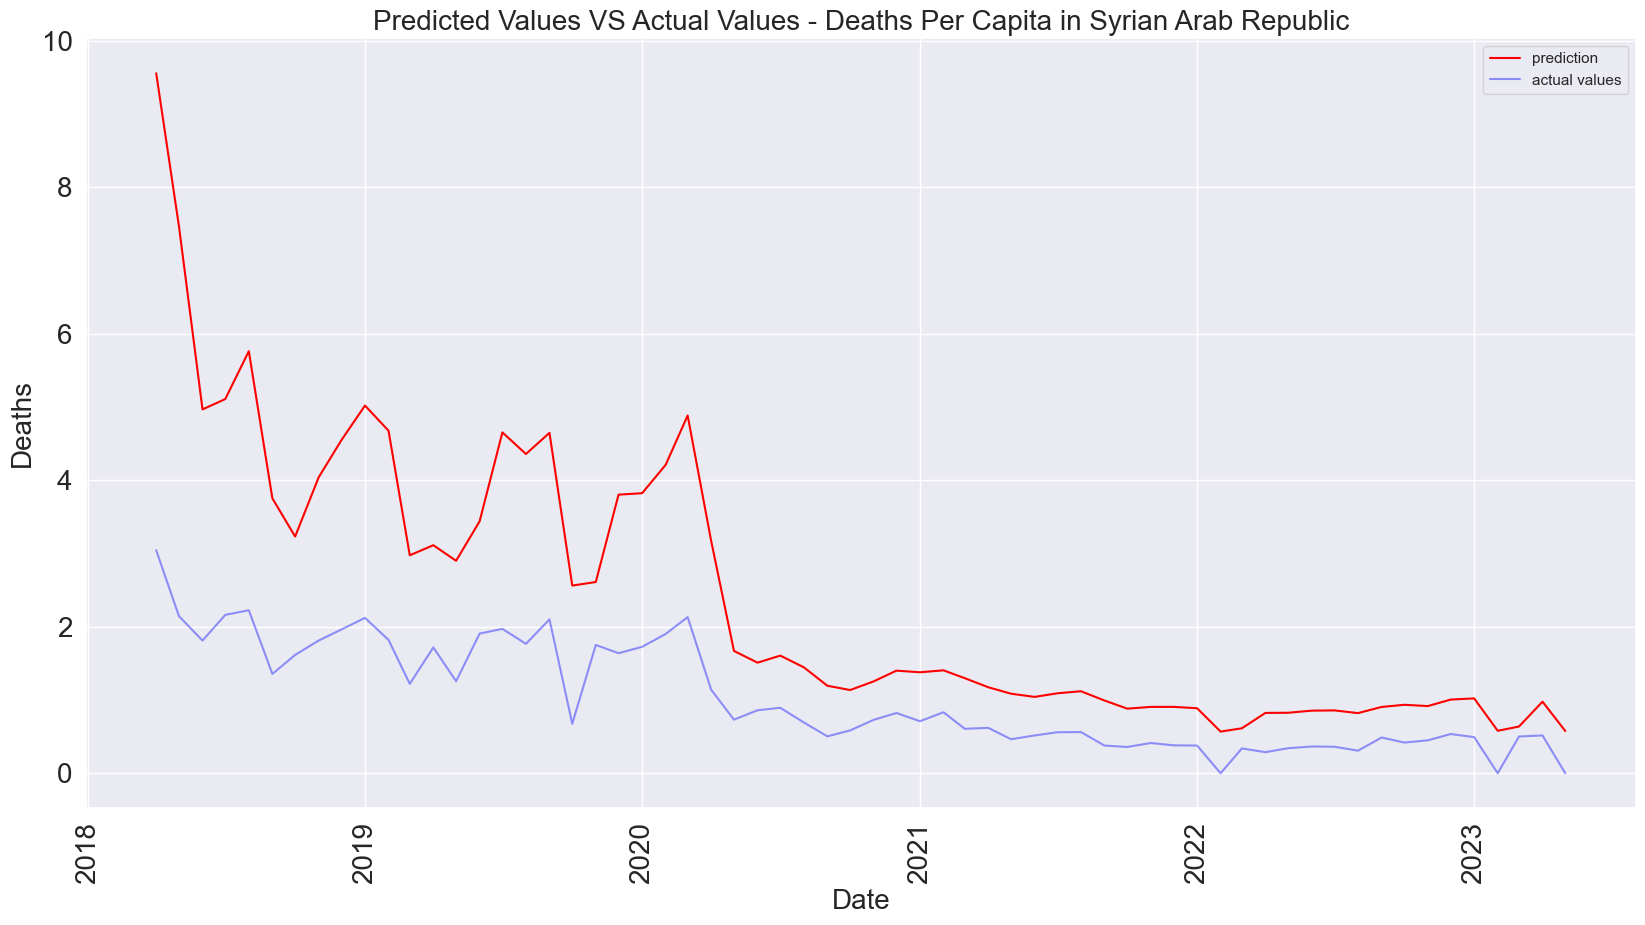

2/2 [==============================] - 0s 5ms/step
Length of y_pred: 63
Length of test_labels: 63
Number of NaN values in y_pred: 0
Number of NaN values in test_labels: 0
Afghanistan - Mean Absolute Error: 1.6185846244325948, Mean Squared Error: 4.102719862928677


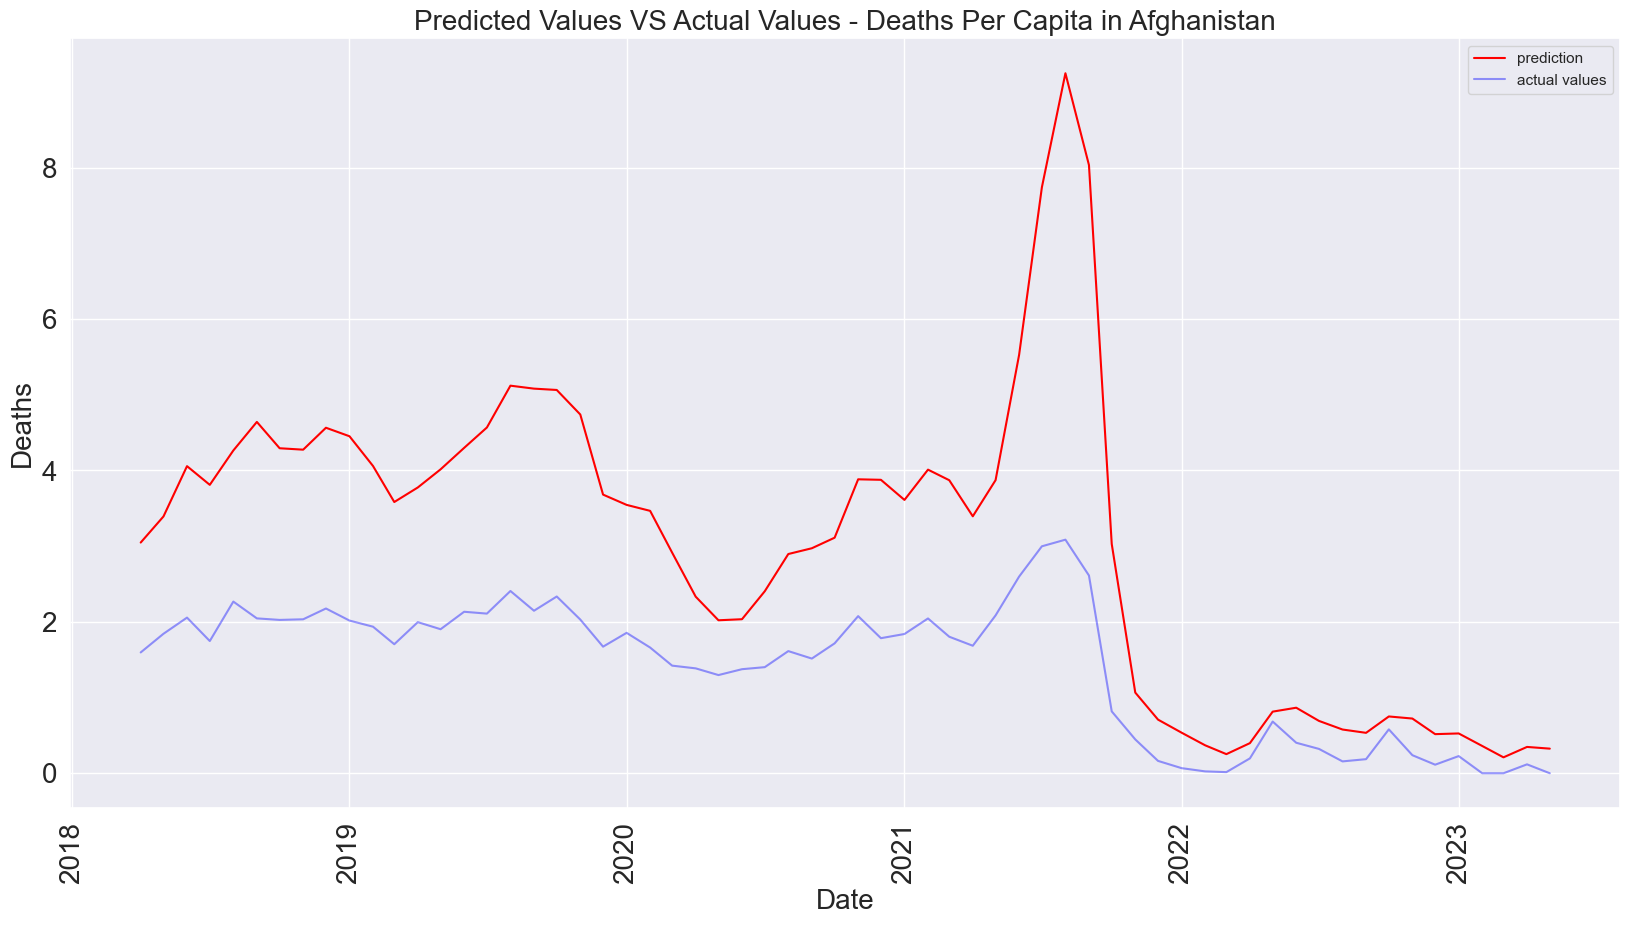

2/2 [==============================] - 0s 5ms/step
Length of y_pred: 63
Length of test_labels: 63
Number of NaN values in y_pred: 0
Number of NaN values in test_labels: 0
Liberia - Mean Absolute Error: 0.0012558489312474081, Mean Squared Error: 2.445093870162374e-05


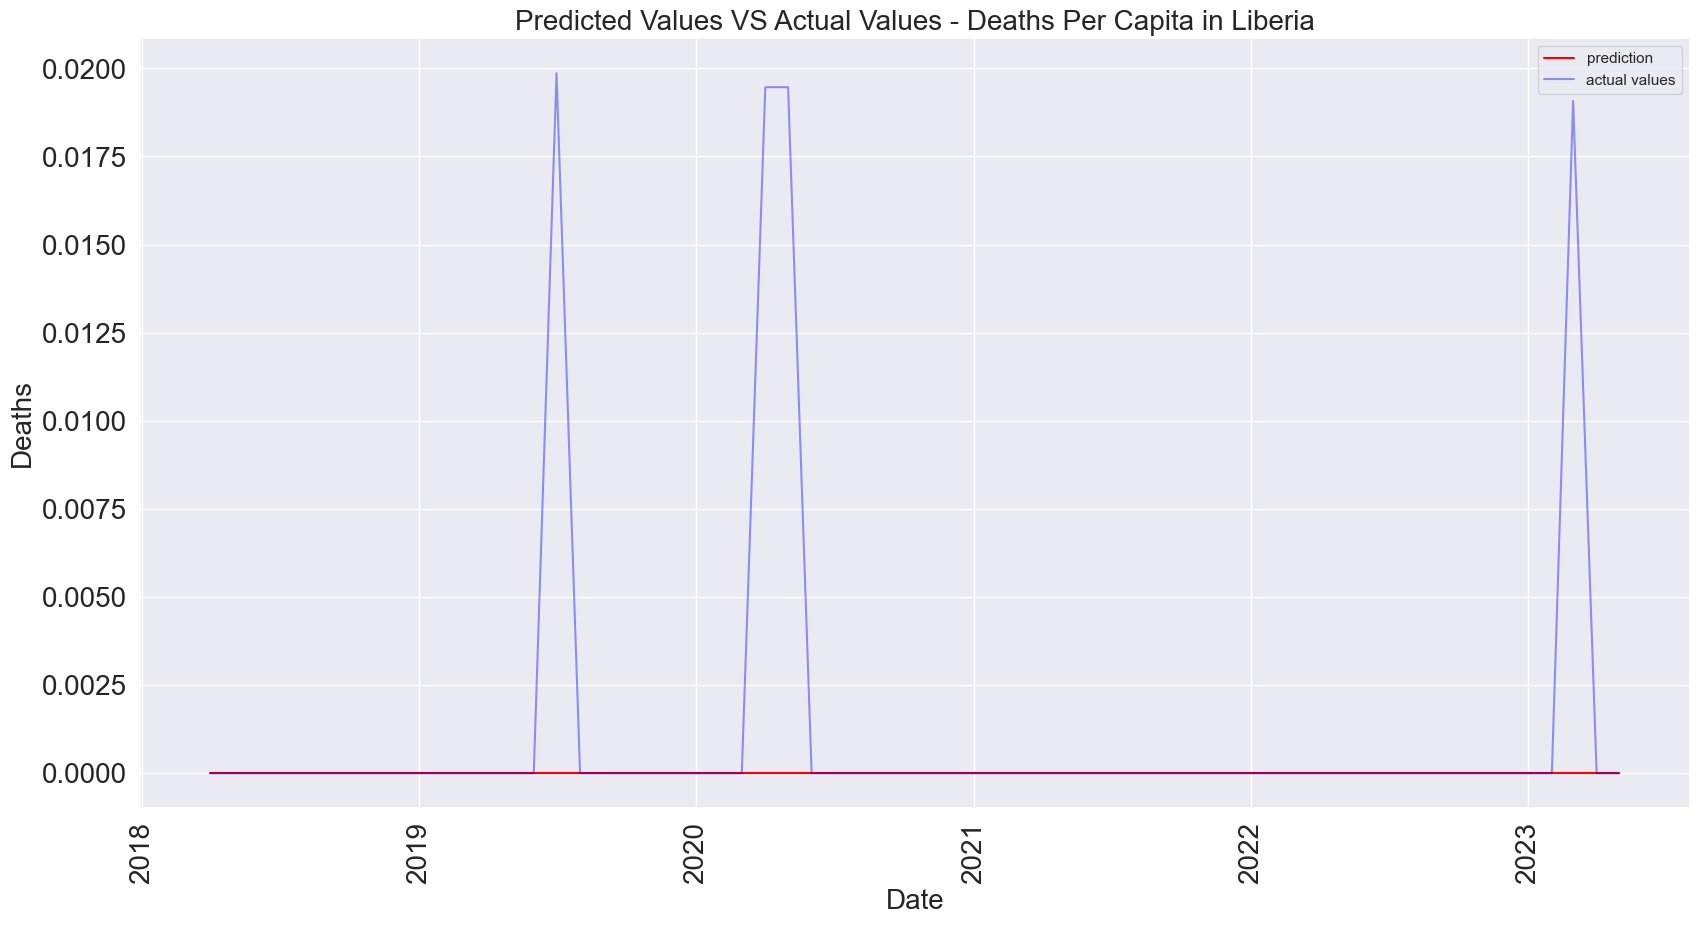

2/2 [==============================] - 0s 4ms/step
Length of y_pred: 63
Length of test_labels: 63
Number of NaN values in y_pred: 0
Number of NaN values in test_labels: 0
Eritrea - Mean Absolute Error: 0.0037911231662725395, Mean Squared Error: 0.00012617236548910098


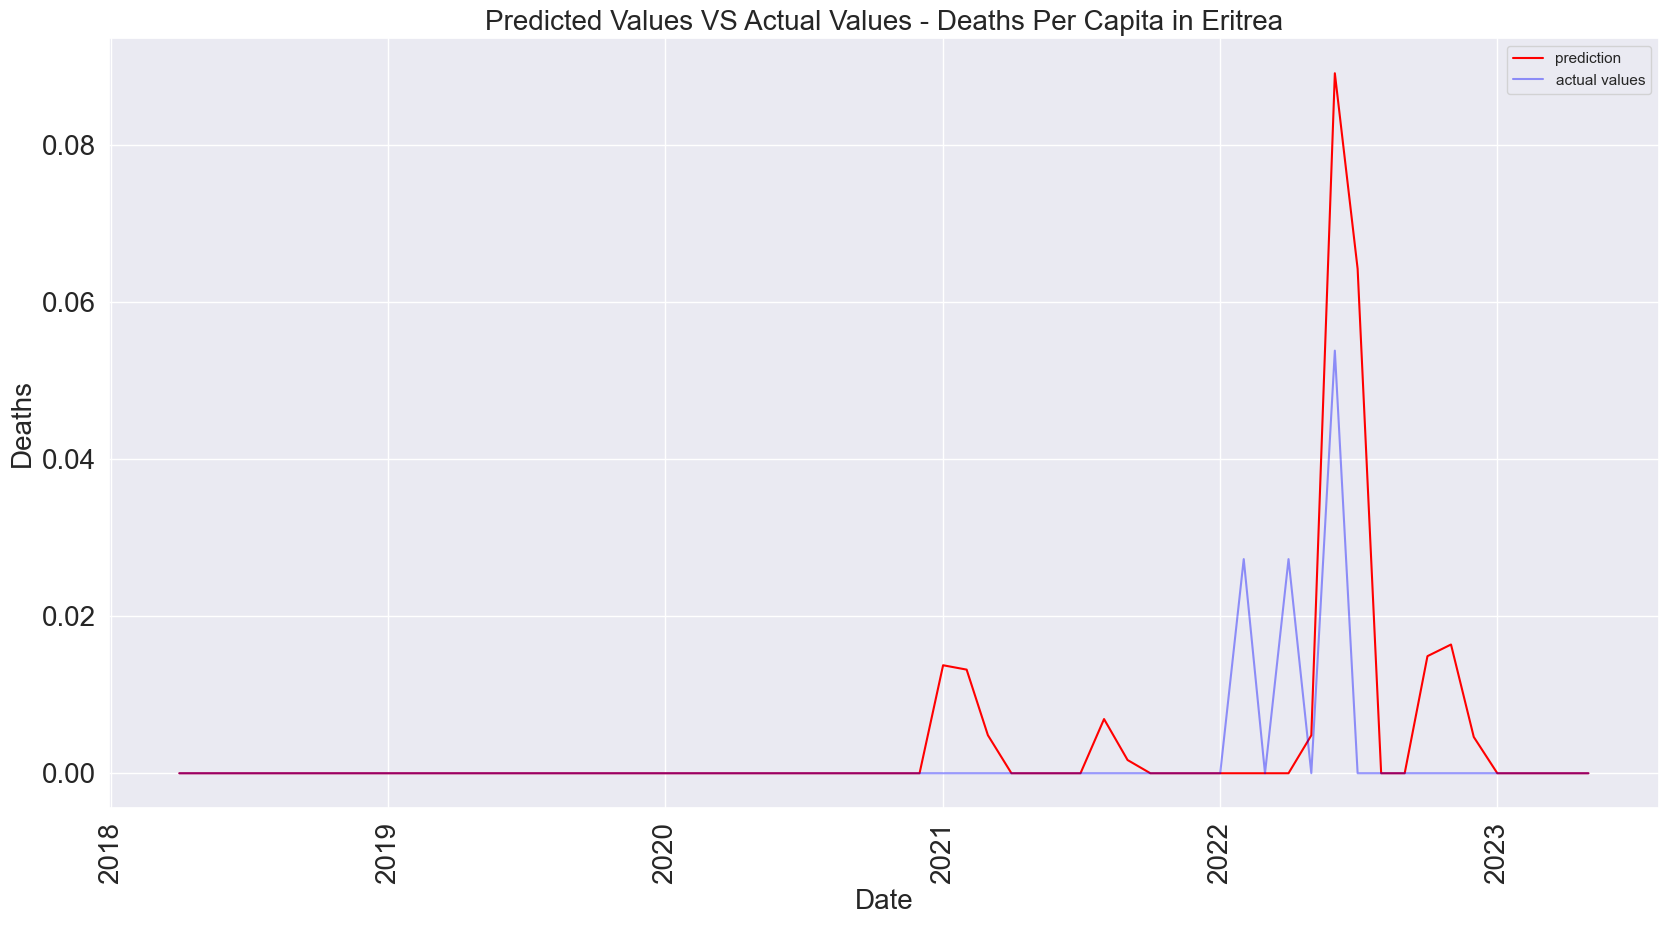

2/2 [==============================] - 0s 5ms/step
Length of y_pred: 63
Length of test_labels: 63
Number of NaN values in y_pred: 0
Number of NaN values in test_labels: 0
Somalia - Mean Absolute Error: 0.19581704184097576, Mean Squared Error: 0.05836965890488855


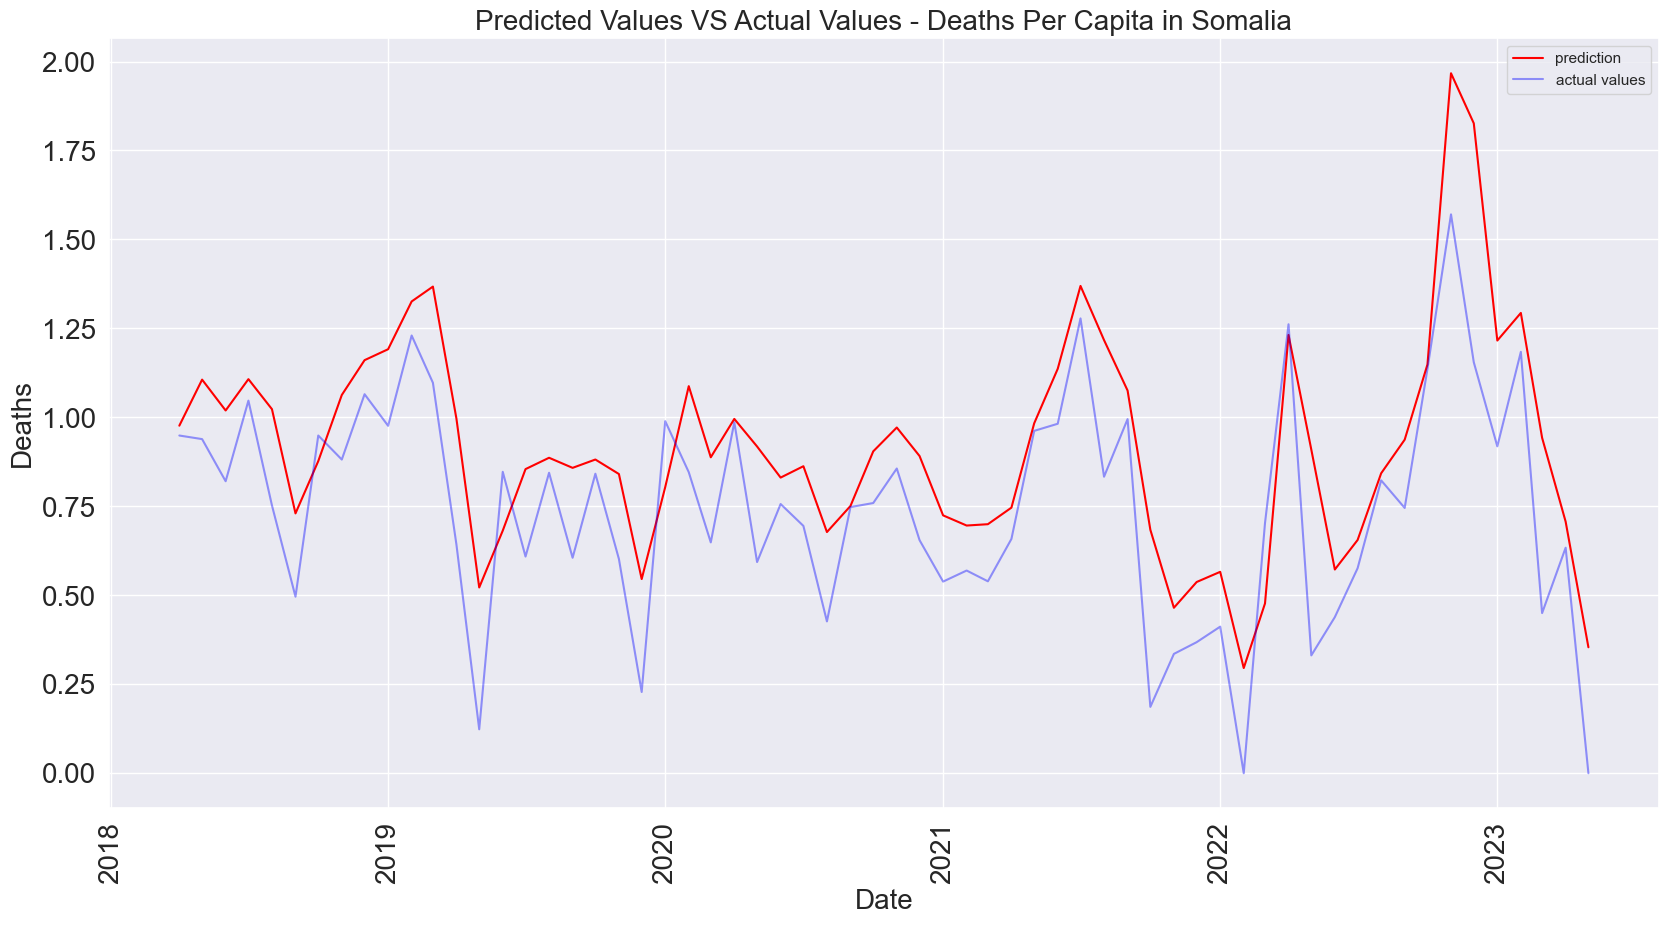

2/2 [==============================] - 0s 4ms/step
Length of y_pred: 63
Length of test_labels: 63
Number of NaN values in y_pred: 0
Number of NaN values in test_labels: 0
Sierra Leone - Mean Absolute Error: 0.0, Mean Squared Error: 0.0


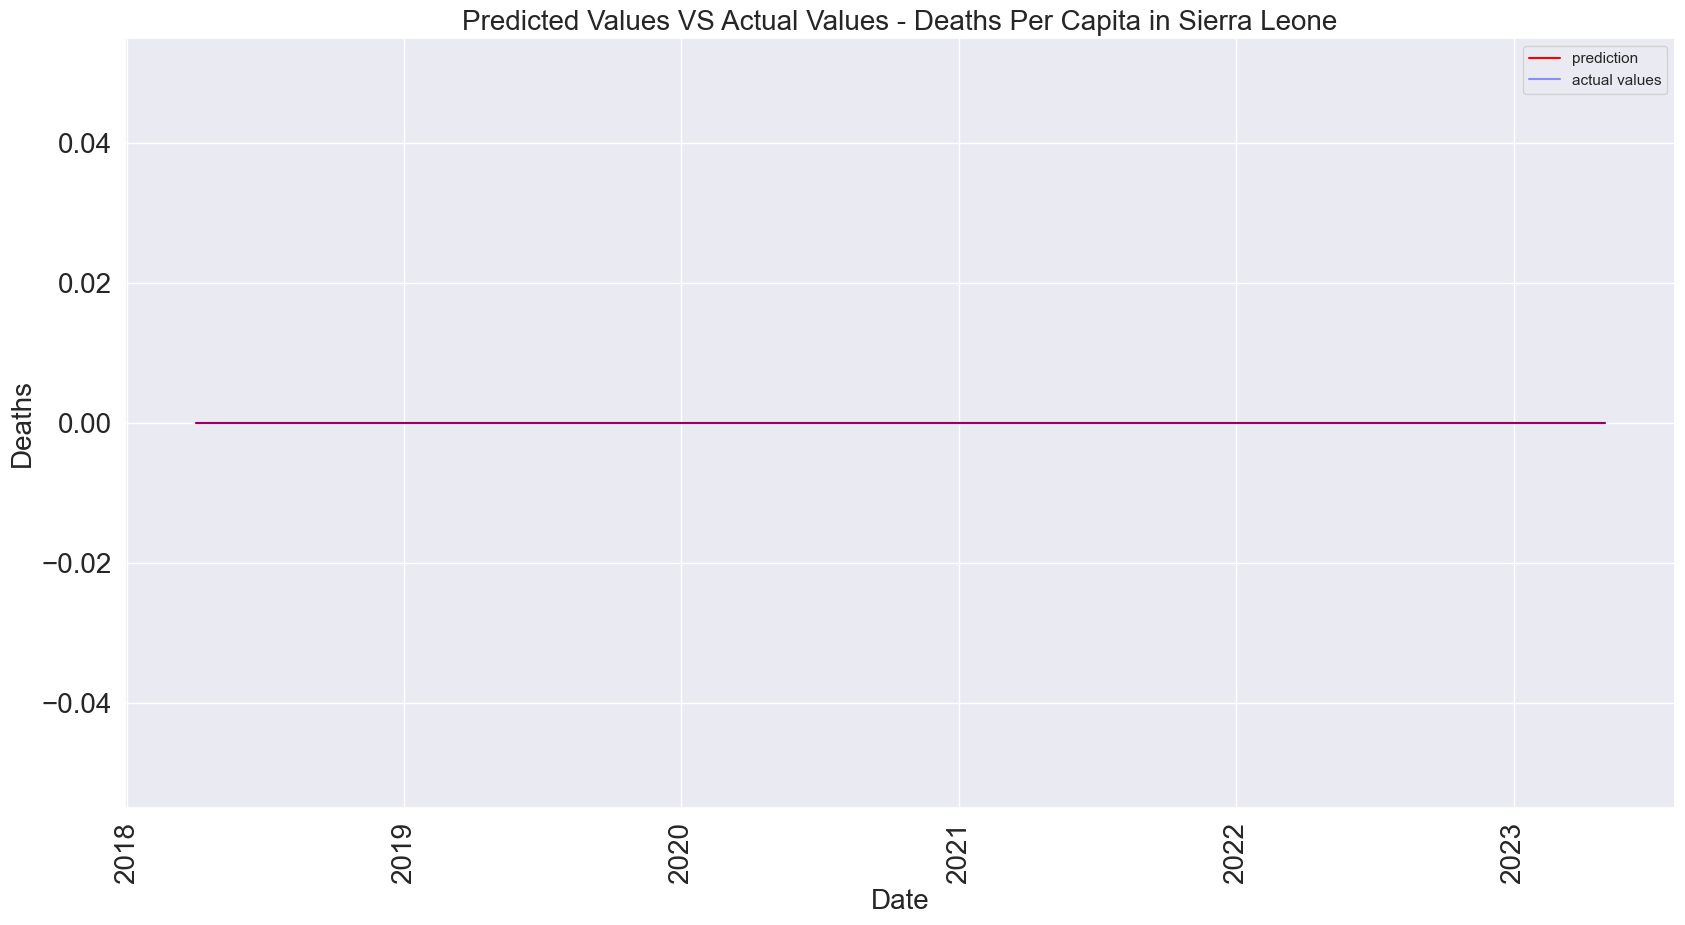

2/2 [==============================] - 0s 5ms/step
Length of y_pred: 63
Length of test_labels: 63
Number of NaN values in y_pred: 0
Number of NaN values in test_labels: 0
Sri Lanka - Mean Absolute Error: 0.0303823653184944, Mean Squared Error: 0.00440962751907867


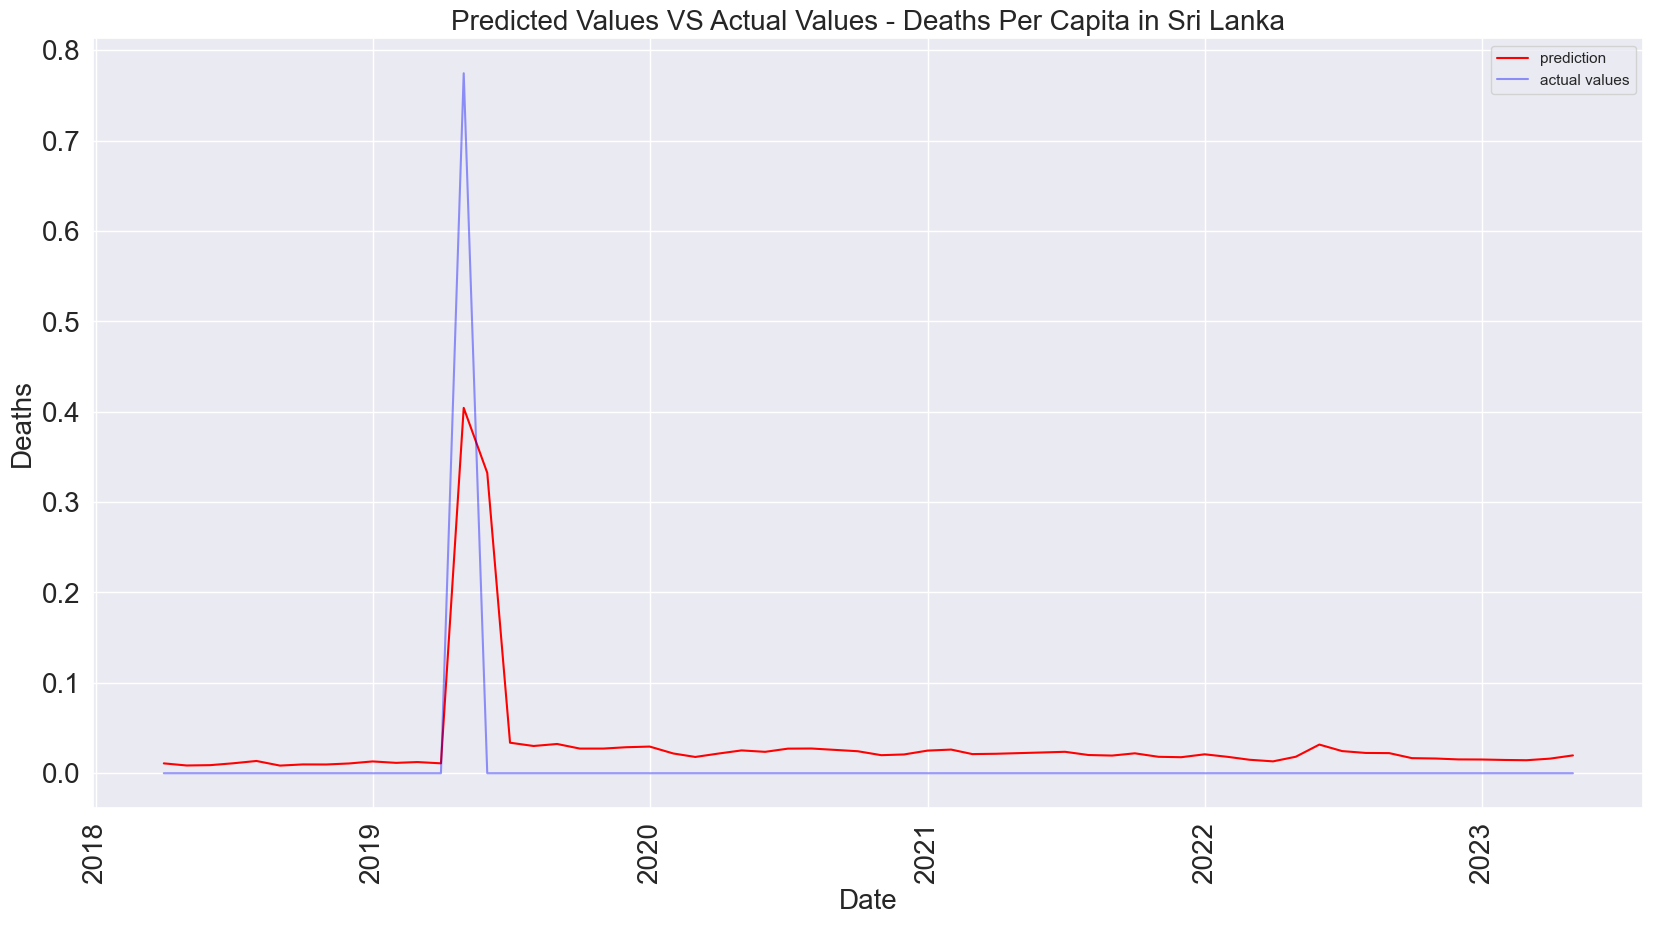

2/2 [==============================] - 0s 9ms/step
Length of y_pred: 63
Length of test_labels: 63
Number of NaN values in y_pred: 0
Number of NaN values in test_labels: 0
Sudan - Mean Absolute Error: 0.11091873321206557, Mean Squared Error: 0.01794894788825372


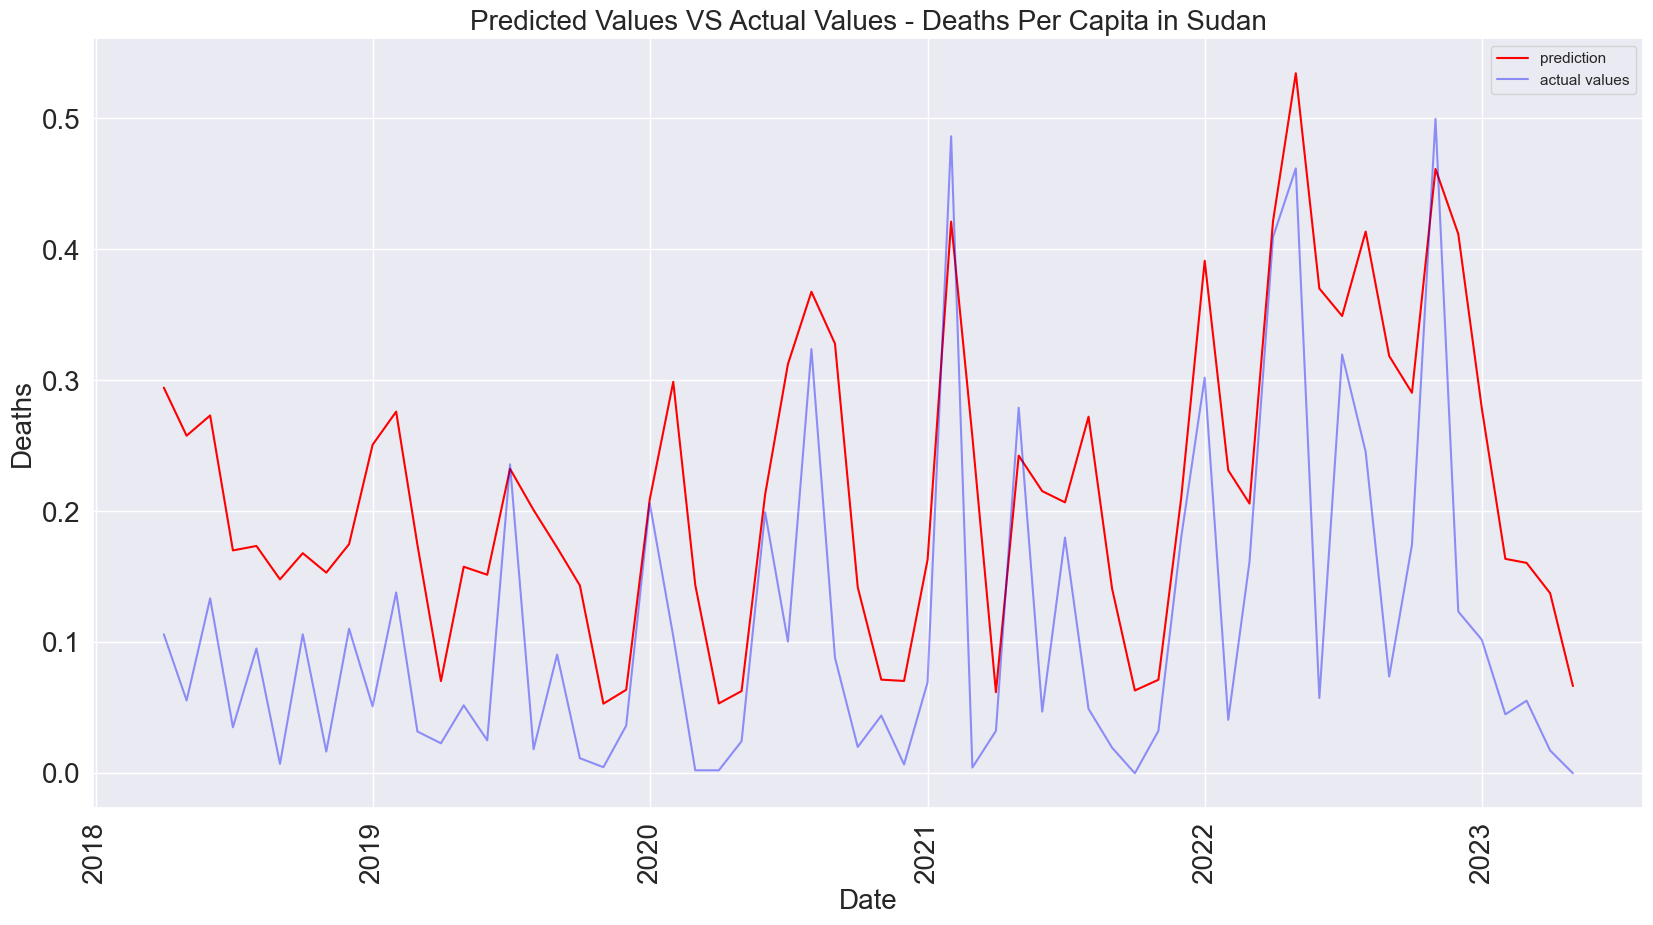

2/2 [==============================] - 0s 5ms/step
Length of y_pred: 63
Length of test_labels: 63
Number of NaN values in y_pred: 0
Number of NaN values in test_labels: 0
Burundi - Mean Absolute Error: 0.06814480267517292, Mean Squared Error: 0.007562410445515887


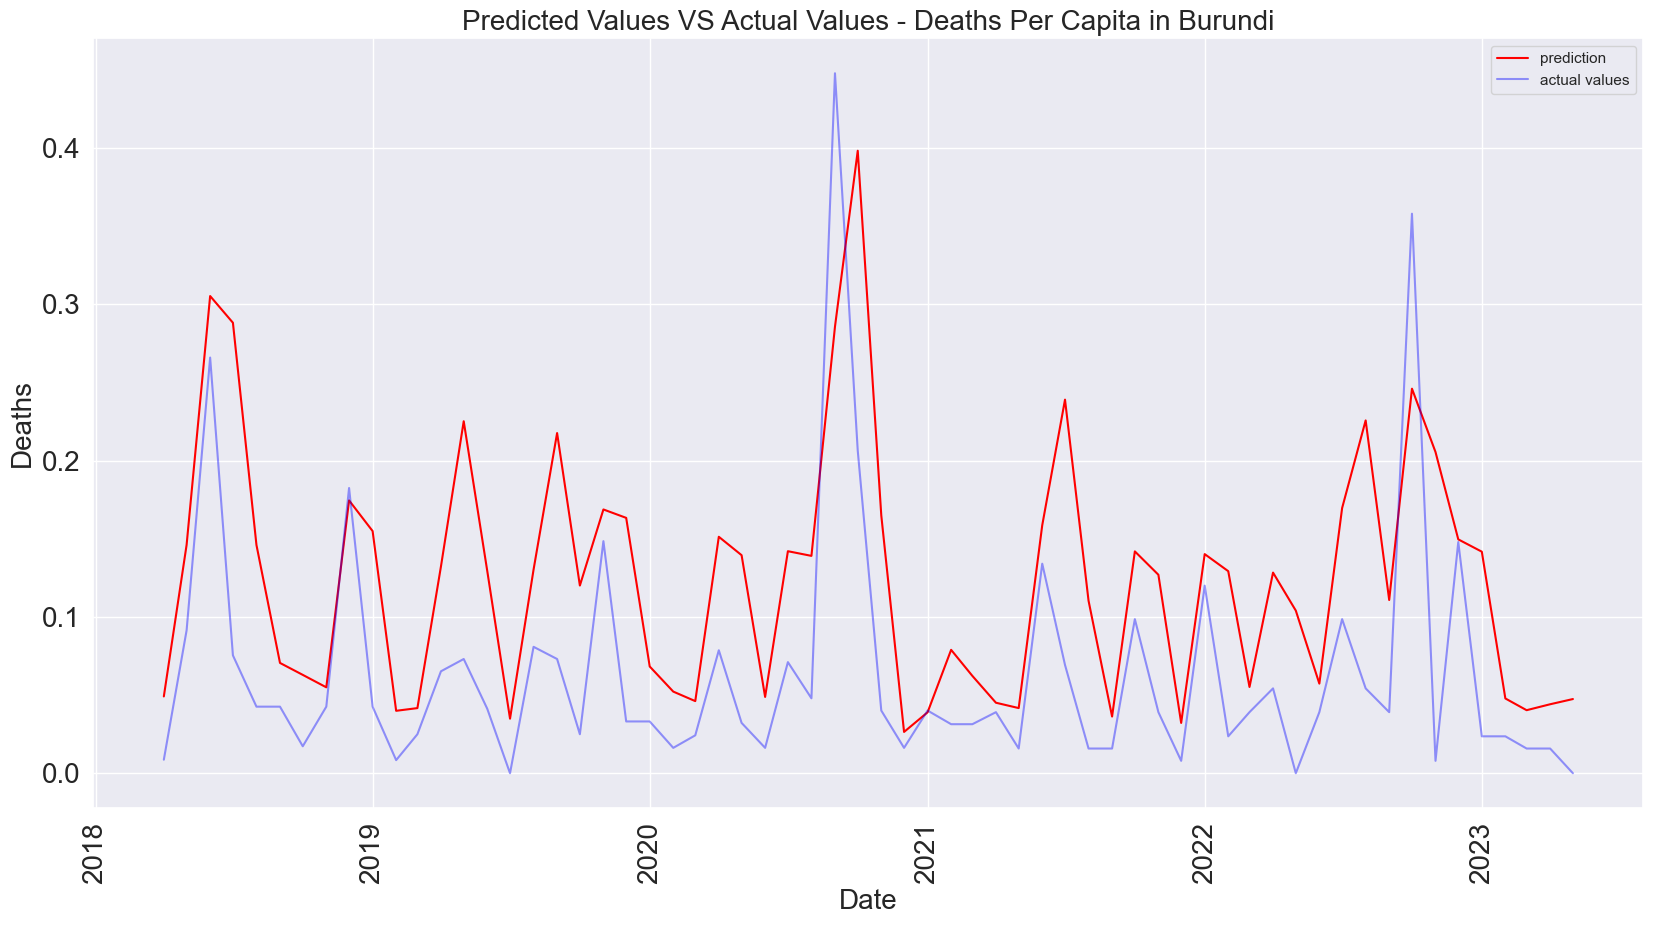

2/2 [==============================] - 0s 4ms/step
Length of y_pred: 63
Length of test_labels: 63
Number of NaN values in y_pred: 0
Number of NaN values in test_labels: 0
Central African Republic - Mean Absolute Error: 0.22180270832287624, Mean Squared Error: 0.07355914186923579


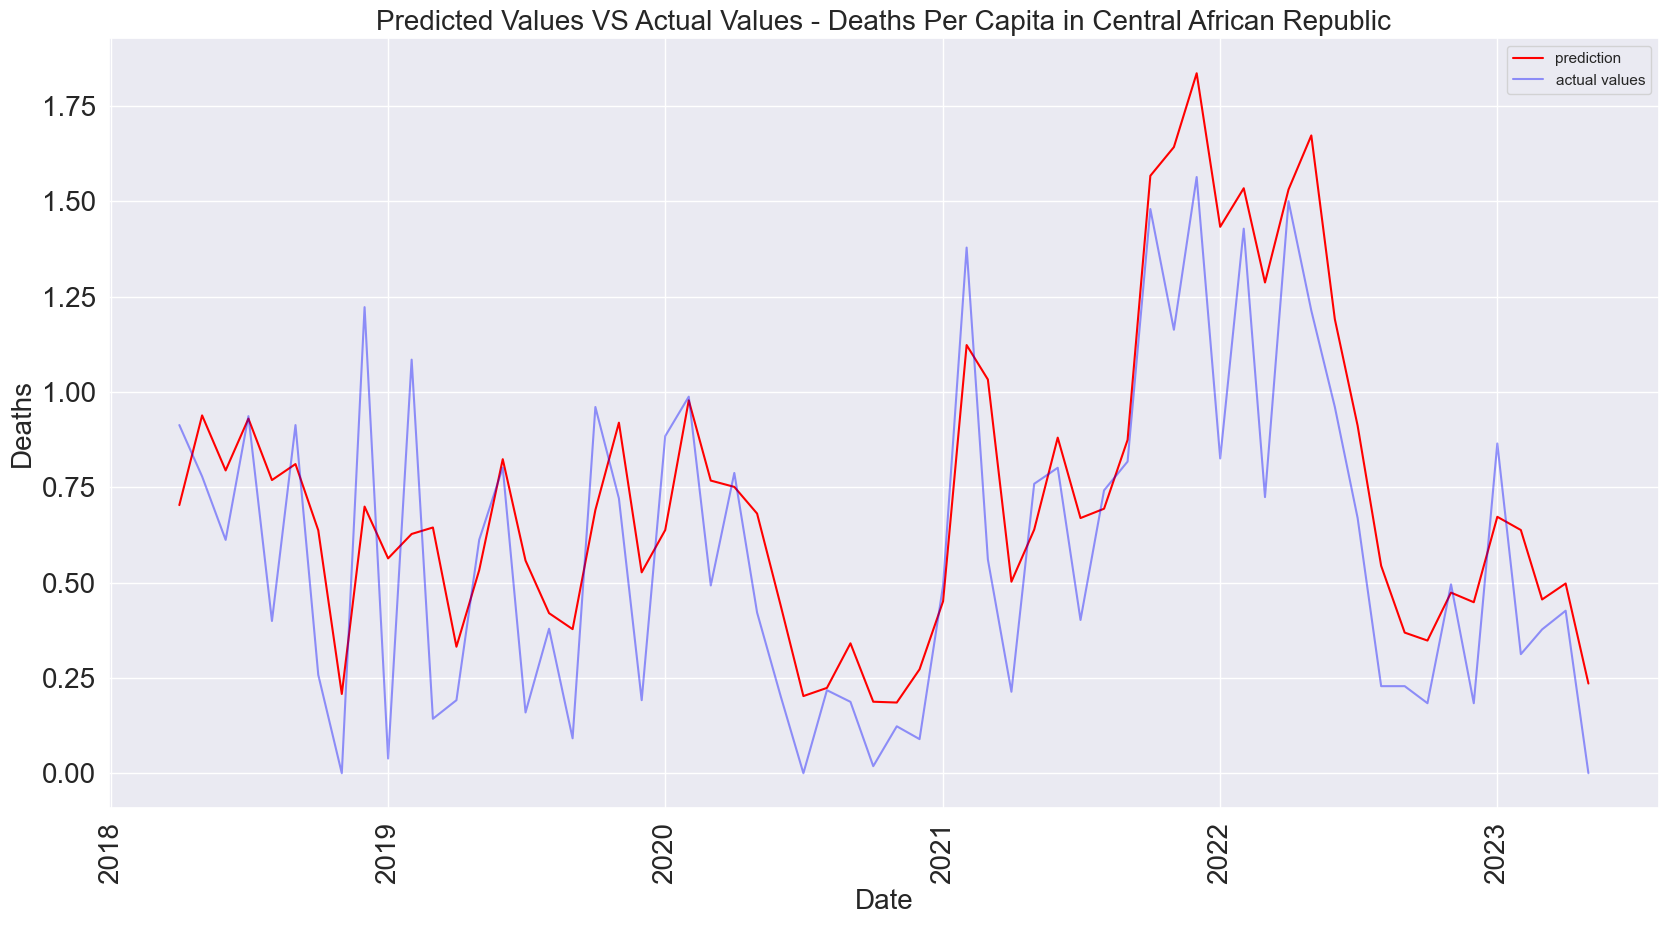

In [44]:
for country_name in top_10_country_names:
    # test data for this country
    country_data = test_data_copy[test_data_copy['country'] == country_name].copy()  

    country_data['country'] = encoder.transform(country_data['country'])
    
    # Re-encode 'country' column
    
    x_test_country, test_labels = reshape_test_data(country_data)

    # generate predictions
    y_pred = model.predict(x_test_country)

    y_pred = np.expm1(y_pred)
    y_test= np.expm1(test_labels)

    # reshape y_pred and test_labels to 2D arrays
    y_pred = y_pred.reshape(-1, 1)
    test_labels = test_labels.reshape(-1, 1)
    
    # Print lengths
    print(f'Length of y_pred: {len(y_pred)}')
    print(f'Length of test_labels: {len(test_labels)}')

    # Print number of NaN values
    print(f'Number of NaN values in y_pred: {np.isnan(y_pred).sum()}')
    print(f'Number of NaN values in test_labels: {np.isnan(test_labels).sum()}')

    # shifting predictions
    y_hat_aligned = y_pred[1:]
    y_test_aligned = test_labels[:-1]

    # calculate errors
    mae = mean_absolute_error(y_test_aligned, y_hat_aligned)
    mse = mean_squared_error(y_test_aligned, y_hat_aligned)

    print('{} - Mean Absolute Error: {}, Mean Squared Error: {}'.format(country_name, mae, mse))

    # plot predicted vs actual
    pa = pd.DataFrame()
    pa['Date'] = pd.to_datetime(country_data.reset_index().year.astype(str) + '-' + country_data.reset_index().month.astype(str) + '-01')[-len(y_hat_aligned):]
    pa['Prediction'] = y_hat_aligned
    pa['Actual Values'] = y_test_aligned  # Flatten to get a 1D array for plotting

    plt.figure(figsize=(20, 10))
    plt.plot(pa['Date'], pa['Prediction'], label='prediction', color='red', alpha=1)
    plt.plot(pa['Date'], pa['Actual Values'], label='actual values', color='blue', alpha=0.4)
    plt.xticks(rotation=90, size=20)
    plt.yticks(size=20)

    plt.ylabel('Deaths', fontsize=20)
    plt.xlabel('Date', fontsize=20)
    plt.title('Predicted Values VS Actual Values - Deaths Per Capita in {}'.format(country_name), fontsize=20)
    plt.legend()
    plt.show()
